# Statistical Evaluation of SG-FIGS Experiment Results

Rigorous statistical evaluation of the SG-FIGS (Synergy-Guided FIGS) experiment across **7 binary classification benchmarks**, comparing three methods: **FIGS**, **RO-FIGS**, and **SG-FIGS**.

This notebook implements 7 analyses:
1. **Friedman test** with Nemenyi post-hoc for overall method ranking
2. **Wilcoxon signed-rank** pairwise tests between all method pairs
3. **Criterion 1**: Per-dataset accuracy + complexity assessment
4. **Criterion 2**: Interpretability score diagnostic (feature-index mismatch analysis)
5. **Criterion 3**: Domain analysis of synergy pairs
6. **Pareto frontier** analysis (accuracy vs complexity trade-off)
7. **Synergy landscape correlation** analysis (what predicts SG-FIGS benefit)

In [ ]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, only needed locally)
if 'google.colab' not in sys.modules:
    _pip('scipy==1.16.3', 'matplotlib==3.10.0')

In [2]:
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"figure.dpi": 120, "font.size": 10})

In [ ]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/test-colab-install/master/eval3_mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("eval3_mini_demo_data.json"):
        with open("eval3_mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded keys: {list(data.keys())}")
print(f"Datasets in accuracy matrix: {list(data['accuracy_matrix'].keys())}")

Loaded keys: ['accuracy_matrix', 'splits_per_dataset', 'synergy_data', 'synergy_pairs', 'dataset_metadata', 'metrics_agg', 'delta_acc_sg_minus_ro']
Datasets in accuracy matrix: ['breast_cancer_wisconsin_diagnostic', 'pima_diabetes', 'heart_statlog', 'ionosphere', 'sonar', 'banknote', 'spectf_heart']


## Configuration

Constants used throughout the evaluation: method names, significance thresholds, and domain knowledge for synergy pair analysis.

In [5]:
# ---------------------------------------------------------------------------
# Constants
# ---------------------------------------------------------------------------
METHODS = ["FIGS", "RO-FIGS", "SG-FIGS"]

# Significance thresholds
ALPHA_005 = 0.05
ALPHA_010 = 0.10

# Criterion 1 thresholds
ACC_DELTA_THRESHOLD = 0.01   # |acc_delta| <= 0.01
SPLIT_RATIO_THRESHOLD = 0.80  # split_ratio <= 0.80

# Criterion 3: minimum datasets with meaningful synergy pairs
CRITERION_3_THRESHOLD = 3

# Nemenyi q values for k=3 methods
NEMENYI_Q_005 = 2.343
NEMENYI_Q_010 = 2.052

# Domain knowledge for Criterion 3 analysis
DOMAIN_KNOWLEDGE = {
    "pima_diabetes": {
        "domain": "medical",
        "known_interactions": {
            ("mass", "age"): "BMI increases with age; age-dependent obesity threshold is a well-known diabetes risk factor",
            ("plas", "mass"): "Glucose-BMI interaction: insulin resistance is amplified by obesity (metabolic syndrome)",
            ("preg", "mass"): "Pregnancy count + BMI: gestational diabetes risk increases with both parity and obesity",
            ("plas", "age"): "Age-dependent glucose tolerance decline is a hallmark of Type 2 diabetes progression",
            ("skin", "age"): "Skin fold thickness (proxy for subcutaneous fat) changes with age; less diagnostic alone",
        },
    },
    "breast_cancer_wisconsin_diagnostic": {
        "domain": "medical",
        "known_interactions": {
            ("radius error", "worst compactness"): "Measurement variability + shape compactness: tumour heterogeneity signals malignancy",
            ("radius error", "worst concavity"): "Size variability + concavity: irregular margins indicate invasive carcinoma",
            ("area error", "worst concavity"): "Area measurement noise + concavity extremes: captures nuclear pleomorphism",
            ("mean area", "worst smoothness"): "Tumour size + surface regularity: large smooth masses are often benign cysts",
            ("mean radius", "worst smoothness"): "Cell size + smoothness: small irregular cells are hallmark of high-grade tumours",
        },
    },
    "heart_statlog": {
        "domain": "medical",
        "known_interactions": {
            ("slope", "number_of_major_vessels"): "ST slope + vessel count: combined indicator of ischemic burden severity",
            ("serum_cholestoral", "oldpeak"): "Cholesterol + ST depression: lipid profile with exercise ECG is standard cardiac risk assessment",
            ("age", "maximum_heart_rate_achieved"): "Age-dependent max HR is a primary fitness/cardiac capacity indicator (220-age rule)",
            ("maximum_heart_rate_achieved", "oldpeak"): "HR response + ST depression: chronotropic incompetence with ischemia signals severe CAD",
            ("oldpeak", "number_of_major_vessels"): "ST depression magnitude + vessel disease count: directly maps to multi-vessel coronary artery disease",
        },
    },
    "banknote": {
        "domain": "signal_processing",
        "known_interactions": {
            ("V2", "V4"): "Wavelet-transformed variance + entropy: captures texture complexity in genuine vs forged notes",
            ("V2", "V3"): "Variance + skewness of wavelet transform: distribution shape features for authentication",
            ("V1", "V2"): "Variance + variance: primary wavelet feature pair for banknote classification",
        },
    },
    "ionosphere": {
        "domain": "radar",
        "known_interactions": {
            ("a12", "a21"): "Radar return signal components: phase-amplitude cross-correlation for ionospheric structure detection",
        },
    },
    "sonar": {
        "domain": "sonar",
        "known_interactions": {
            ("attribute_36", "attribute_46"): "Mid-to-high frequency energy bands: spectral shape discriminates rock vs metal",
        },
    },
    "spectf_heart": {
        "domain": "medical",
        "known_interactions": {
            ("F5R", "F14S"): "Rest + stress SPECT features: perfusion comparison between rest and stress indicates ischemia",
        },
    },
}

# Extract data from loaded JSON
acc_per_dataset = data["accuracy_matrix"]
splits_per_dataset = data["splits_per_dataset"]
synergy_pairs = data["synergy_pairs"]
dataset_metadata = data["dataset_metadata"]
synergy_data = data["synergy_data"]
delta_acc_sg_minus_ro = data["delta_acc_sg_minus_ro"]

print(f"Methods: {METHODS}")
print(f"Datasets: {list(acc_per_dataset.keys())}")
print(f"N datasets: {len(acc_per_dataset)}")

Methods: ['FIGS', 'RO-FIGS', 'SG-FIGS']
Datasets: ['breast_cancer_wisconsin_diagnostic', 'pima_diabetes', 'heart_statlog', 'ionosphere', 'sonar', 'banknote', 'spectf_heart']
N datasets: 7


## 1. Friedman Test with Nemenyi Post-Hoc

Non-parametric test comparing 3 methods across 7 datasets. The Friedman test checks whether method rankings differ significantly. If significant at alpha=0.10, Nemenyi post-hoc identifies which pairs differ.

In [6]:
# Filter to datasets with all 3 methods
complete_datasets = [
    ds for ds, ma in acc_per_dataset.items()
    if all(m in ma for m in METHODS)
]

N = len(complete_datasets)
k = len(METHODS)
print(f"Using {N} datasets with all {k} methods: {complete_datasets}")

# Build accuracy matrix: N x k
acc_matrix = np.zeros((N, k))
for i, ds_name in enumerate(complete_datasets):
    for j, method in enumerate(METHODS):
        acc_matrix[i, j] = acc_per_dataset[ds_name][method]

# Compute ranks per dataset (higher accuracy = lower rank = better)
rank_matrix = np.zeros((N, k))
for i in range(N):
    rank_matrix[i] = stats.rankdata(-acc_matrix[i], method="average")

avg_ranks = np.mean(rank_matrix, axis=0)
print(f"\nAverage ranks: {dict(zip(METHODS, avg_ranks.tolist()))}")

# Friedman test
stat, p_value = stats.friedmanchisquare(*[acc_matrix[:, j] for j in range(k)])
print(f"Friedman chi2={stat:.4f}, p={p_value:.6f}")
print(f"Significant at alpha=0.05: {p_value < ALPHA_005}")
print(f"Significant at alpha=0.10: {p_value < ALPHA_010}")

# Nemenyi post-hoc
if p_value < ALPHA_010:
    cd_005 = NEMENYI_Q_005 * np.sqrt(k * (k + 1) / (6 * N))
    cd_010 = NEMENYI_Q_010 * np.sqrt(k * (k + 1) / (6 * N))
    print(f"\nNemenyi CD (alpha=0.05): {cd_005:.4f}")
    print(f"Nemenyi CD (alpha=0.10): {cd_010:.4f}")
    for i_m in range(k):
        for j_m in range(i_m + 1, k):
            rank_diff = abs(avg_ranks[i_m] - avg_ranks[j_m])
            print(f"  {METHODS[i_m]} vs {METHODS[j_m]}: rank_diff={rank_diff:.4f}, "
                  f"sig_005={rank_diff > cd_005}, sig_010={rank_diff > cd_010}")
else:
    print("\nFriedman test not significant — Nemenyi post-hoc not warranted")

Using 7 datasets with all 3 methods: ['breast_cancer_wisconsin_diagnostic', 'pima_diabetes', 'heart_statlog', 'ionosphere', 'sonar', 'banknote', 'spectf_heart']

Average ranks: {'FIGS': 2.4285714285714284, 'RO-FIGS': 1.4285714285714286, 'SG-FIGS': 2.142857142857143}
Friedman chi2=3.7143, p=0.156118
Significant at alpha=0.05: False
Significant at alpha=0.10: False

Friedman test not significant — Nemenyi post-hoc not warranted


## 2. Wilcoxon Signed-Rank Pairwise Tests

Pairwise comparison of each method pair using Wilcoxon signed-rank test on balanced accuracy differences across datasets. Note: with N=7, minimum achievable p-value is 1/128 = 0.0078.

In [7]:
pairs_to_test = [("FIGS", "RO-FIGS"), ("FIGS", "SG-FIGS"), ("RO-FIGS", "SG-FIGS")]
min_p = 1 / (2**N)
print(f"With N={N}, minimum achievable p-value = {min_p:.4f}\n")

wilcoxon_results = {}
for m1, m2 in pairs_to_test:
    diffs = [acc_per_dataset[ds][m1] - acc_per_dataset[ds][m2] for ds in complete_datasets]
    diffs_arr = np.array(diffs)
    mean_diff = float(np.mean(diffs_arr))
    std_diff = float(np.std(diffs_arr, ddof=1))

    try:
        stat_val, p_val = stats.wilcoxon(diffs_arr, alternative="two-sided", method="exact")
        test_ok = True
    except ValueError:
        stat_val, p_val = float("nan"), 1.0
        test_ok = False

    wilcoxon_results[f"{m1}_vs_{m2}"] = {
        "mean_diff": mean_diff, "p_value": p_val, "stat": stat_val
    }

    direction = "better" if mean_diff > 0 else "worse"
    print(f"{m1} vs {m2}:")
    print(f"  mean_diff={mean_diff:+.6f}, stat={stat_val}, p={p_val:.6f}")
    print(f"  {m1} is {direction} than {m2} by {abs(mean_diff):.4f}")
    print(f"  Significant at 0.05: {p_val < ALPHA_005}, at 0.10: {p_val < ALPHA_010}")
    print()

With N=7, minimum achievable p-value = 0.0078

FIGS vs RO-FIGS:
  mean_diff=-0.017697, stat=4.0, p=0.109375
  FIGS is worse than RO-FIGS by 0.0177
  Significant at 0.05: False, at 0.10: False

FIGS vs SG-FIGS:
  mean_diff=-0.004722, stat=13.0, p=0.937500
  FIGS is worse than SG-FIGS by 0.0047
  Significant at 0.05: False, at 0.10: False

RO-FIGS vs SG-FIGS:
  mean_diff=+0.012975, stat=5.0, p=0.156250
  RO-FIGS is better than SG-FIGS by 0.0130
  Significant at 0.05: False, at 0.10: False



## 3. Criterion 1: Per-Dataset Accuracy + Complexity Assessment

For each dataset, check if SG-FIGS achieves competitive accuracy (|delta| <= 0.01) with at least 20% fewer splits compared to RO-FIGS.

In [8]:
eligible_datasets = [
    ds for ds in acc_per_dataset
    if "SG-FIGS" in acc_per_dataset[ds] and "RO-FIGS" in acc_per_dataset[ds]
]

meets_both = 0
meets_alternative = 0

print(f"{'Dataset':<40} {'Acc Delta':>10} {'Split Ratio':>12} {'Assessment':>15}")
print("-" * 80)

for ds_name in eligible_datasets:
    sg_acc = acc_per_dataset[ds_name]["SG-FIGS"]
    ro_acc = acc_per_dataset[ds_name]["RO-FIGS"]
    sg_splits = splits_per_dataset[ds_name].get("SG-FIGS", 0)
    ro_splits = splits_per_dataset[ds_name].get("RO-FIGS", 0)

    acc_delta = sg_acc - ro_acc
    split_ratio = sg_splits / ro_splits if ro_splits > 0 else float("inf")

    acc_within_1pct = abs(acc_delta) <= ACC_DELTA_THRESHOLD
    splits_20pct_fewer = split_ratio <= SPLIT_RATIO_THRESHOLD
    higher_acc_same_complexity = acc_delta > ACC_DELTA_THRESHOLD and split_ratio <= 1.10

    assessment = "FAIL"
    if acc_within_1pct and splits_20pct_fewer:
        assessment = "PASS_MAIN"
        meets_both += 1
    elif higher_acc_same_complexity:
        assessment = "PASS_ALT"
        meets_alternative += 1

    print(f"{ds_name:<40} {acc_delta:>+10.4f} {split_ratio:>12.2f} {assessment:>15}")

n_eligible = len(eligible_datasets)
print(f"\nSummary: {meets_both}/{n_eligible} pass main, "
      f"{meets_alternative}/{n_eligible} pass alternative, "
      f"{meets_both + meets_alternative}/{n_eligible} pass either")

Dataset                                   Acc Delta  Split Ratio      Assessment
--------------------------------------------------------------------------------
breast_cancer_wisconsin_diagnostic          -0.0151         1.67            FAIL
pima_diabetes                               -0.0057         2.50            FAIL
heart_statlog                               -0.0164         0.33            FAIL
ionosphere                                  -0.0034         0.50       PASS_MAIN
sonar                                       +0.0098         1.67            FAIL
banknote                                    +0.0015         0.33       PASS_MAIN
spectf_heart                                -0.0616         1.00            FAIL

Summary: 2/7 pass main, 0/7 pass alternative, 2/7 pass either


## 4. Criterion 2: Interpretability Score Diagnostic

Diagnoses why 5/7 datasets scored 0.000 on `split_interpretability_score`. Analyzes feature-index mismatch from MI prefiltering, axis-aligned fallback, and high-dimensionality issues.

In [9]:
print(f"{'Dataset':<40} {'N Feat':>7} {'N Used':>7} {'High-D':>7} {'Mismatch':>9} {'SG Splits':>10}")
print("-" * 85)

n_mismatch = 0
n_high_dim = 0
n_low_complexity = 0

for ds_name, meta in dataset_metadata.items():
    n_features = meta["n_features"]
    n_used = meta["n_features_used_in_synergy"]
    is_high_dim = meta["is_high_dim"]
    mismatch = meta["feature_index_mismatch_likely"]
    sg_splits = meta["mean_sg_figs_splits"]

    if mismatch:
        n_mismatch += 1
    if is_high_dim:
        n_high_dim += 1
    if sg_splits <= 5:
        n_low_complexity += 1

    # Identify likely causes
    causes = []
    if mismatch:
        causes.append(f"index mismatch ({n_features} -> {n_used})")
    if is_high_dim:
        causes.append(f"high-dim ({meta['pid_method']})")
    if sg_splits <= 5:
        causes.append("low complexity fallback")

    print(f"{ds_name:<40} {n_features:>7} {n_used:>7} {'Yes' if is_high_dim else 'No':>7} "
          f"{'Yes' if mismatch else 'No':>9} {sg_splits:>10.1f}")
    if causes:
        print(f"  -> Likely causes: {', '.join(causes)}")

print(f"\nSummary: {n_mismatch} with index mismatch, {n_high_dim} high-dim, "
      f"{n_low_complexity} low-complexity fallback")

Dataset                                   N Feat  N Used  High-D  Mismatch  SG Splits
-------------------------------------------------------------------------------------
breast_cancer_wisconsin_diagnostic            30      30     Yes        No       25.0
  -> Likely causes: high-dim (MMI)
pima_diabetes                                  8       8      No        No       25.0
heart_statlog                                 13      13      No        No        5.0
  -> Likely causes: low complexity fallback
ionosphere                                    34      30     Yes       Yes        5.0
  -> Likely causes: index mismatch (34 -> 30), high-dim (MMI), low complexity fallback
sonar                                         60      30     Yes       Yes       25.0
  -> Likely causes: index mismatch (60 -> 30), high-dim (MMI)
banknote                                       4       4      No        No        5.0
  -> Likely causes: low complexity fallback
spectf_heart                            

## 5. Criterion 3: Domain Analysis of Synergy Pairs

Maps top-5 synergy pairs per dataset to domain knowledge. Checks whether >= 3 datasets have domain-meaningful synergistic feature pairs.

In [10]:
target_datasets = [
    "pima_diabetes", "breast_cancer_wisconsin_diagnostic", "heart_statlog",
    "banknote", "ionosphere", "sonar", "spectf_heart",
]

datasets_with_meaningful_pairs = 0

for ds_name in target_datasets:
    if ds_name not in synergy_pairs:
        print(f"  {ds_name}: no synergy pairs available")
        continue

    top_5 = synergy_pairs[ds_name][:5]
    domain_info = DOMAIN_KNOWLEDGE.get(ds_name, {})
    known = domain_info.get("known_interactions", {})
    domain = domain_info.get("domain", "unknown")

    meaningful_count = 0
    for pair in top_5:
        fi, fj = pair["feature_i"], pair["feature_j"]
        explanation = known.get((fi, fj)) or known.get((fj, fi))
        if explanation is not None:
            meaningful_count += 1

    has_meaningful = meaningful_count >= 2
    if has_meaningful:
        datasets_with_meaningful_pairs += 1

    status = "PASS" if has_meaningful else "FAIL"
    print(f"{ds_name} ({domain}): {meaningful_count}/{len(top_5)} "
          f"pairs domain-meaningful -> {status}")

criterion_met = datasets_with_meaningful_pairs >= CRITERION_3_THRESHOLD
print(f"\n{datasets_with_meaningful_pairs} of {len(target_datasets)} datasets have "
      f"meaningful pairs (threshold: >= {CRITERION_3_THRESHOLD}). "
      f"Criterion {'MET' if criterion_met else 'NOT MET'}.")

pima_diabetes (medical): 5/5 pairs domain-meaningful -> PASS
breast_cancer_wisconsin_diagnostic (medical): 5/5 pairs domain-meaningful -> PASS
heart_statlog (medical): 5/5 pairs domain-meaningful -> PASS
banknote (signal_processing): 3/5 pairs domain-meaningful -> PASS
ionosphere (radar): 1/5 pairs domain-meaningful -> FAIL
sonar (sonar): 1/5 pairs domain-meaningful -> FAIL
spectf_heart (medical): 1/5 pairs domain-meaningful -> FAIL

4 of 7 datasets have meaningful pairs (threshold: >= 3). Criterion MET.


## 6. Pareto Frontier Analysis

Accuracy vs complexity (number of splits) trade-off. A method is Pareto-dominated if another method achieves both higher accuracy AND fewer splits.

In [11]:
# Compute mean accuracy and mean splits across all eligible datasets
method_stats = {}
for method in METHODS:
    accs = [acc_per_dataset[ds][method] for ds in acc_per_dataset if method in acc_per_dataset[ds]]
    splits = [splits_per_dataset[ds][method] for ds in splits_per_dataset if method in splits_per_dataset[ds]]
    if accs and splits:
        mean_acc = float(np.mean(accs))
        mean_splits = float(np.mean(splits))
        efficiency = mean_acc / mean_splits if mean_splits > 0 else 0.0
        method_stats[method] = {
            "mean_accuracy": mean_acc,
            "mean_n_splits": mean_splits,
            "efficiency": efficiency,
        }

# Determine Pareto dominance
pareto_dominant = []
pareto_dominated = []
for m1 in method_stats:
    is_dominated = False
    for m2 in method_stats:
        if m1 == m2:
            continue
        s1, s2 = method_stats[m1], method_stats[m2]
        if (s2["mean_accuracy"] >= s1["mean_accuracy"]
            and s2["mean_n_splits"] <= s1["mean_n_splits"]
            and (s2["mean_accuracy"] > s1["mean_accuracy"]
                 or s2["mean_n_splits"] < s1["mean_n_splits"])):
            is_dominated = True
            break
    if not is_dominated:
        pareto_dominant.append(m1)
    else:
        pareto_dominated.append(m1)

print(f"{'Method':<12} {'Mean Acc':>10} {'Mean Splits':>12} {'Efficiency':>12} {'Pareto':>10}")
print("-" * 58)
for m, s in method_stats.items():
    status = "DOMINANT" if m in pareto_dominant else "dominated"
    print(f"{m:<12} {s['mean_accuracy']:>10.4f} {s['mean_n_splits']:>12.2f} "
          f"{s['efficiency']:>12.6f} {status:>10}")

print(f"\nPareto-optimal: {pareto_dominant}")
print(f"Pareto-dominated: {pareto_dominated}")

Method         Mean Acc  Mean Splits   Efficiency     Pareto
----------------------------------------------------------
FIGS             0.8340        11.43     0.072975   DOMINANT
RO-FIGS          0.8517        13.57     0.062757   DOMINANT
SG-FIGS          0.8387        15.00     0.055915  dominated

Pareto-optimal: ['FIGS', 'RO-FIGS']
Pareto-dominated: ['SG-FIGS']


## 7. Synergy Landscape Correlation Analysis

Correlates synergy landscape features with SG-FIGS relative performance (delta_acc = SG-FIGS - RO-FIGS). Positive Spearman rho indicates higher feature values predict better SG-FIGS performance.

In [12]:
# Build feature matrix and target vector
eligible_corr = [ds for ds in complete_datasets if ds in synergy_data]
feature_names = ["synergy_mean", "synergy_std", "graph_density", "mi_comparison_jaccard"]

X = np.array([[synergy_data[ds].get(fn, 0.0) or 0.0 for fn in feature_names]
              for ds in eligible_corr])
y = np.array([delta_acc_sg_minus_ro[ds] for ds in eligible_corr])

print(f"Correlating {len(feature_names)} synergy features with SG-FIGS relative benefit")
print(f"Using {len(eligible_corr)} datasets\n")

# Compute Spearman correlations
correlations = []
for i, fn in enumerate(feature_names):
    x_col = X[:, i]
    if np.std(x_col) < 1e-12:
        correlations.append((fn, 0.0, 1.0))
        continue
    rho, p_val = stats.spearmanr(x_col, y)
    correlations.append((fn, float(rho), float(p_val)))

# Sort by absolute correlation
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"{'Feature':<30} {'Spearman rho':>13} {'p-value':>10} {'Sig@0.10':>10}")
print("-" * 65)
for fn, rho, p_val in correlations:
    sig = "Yes" if p_val < ALPHA_010 else "No"
    print(f"{fn:<30} {rho:>+13.4f} {p_val:>10.4f} {sig:>10}")

# Per-dataset details
print(f"\nPer-dataset SG-FIGS vs RO-FIGS delta:")
for ds in eligible_corr:
    delta = delta_acc_sg_minus_ro[ds]
    syn_mean = synergy_data[ds].get("synergy_mean", 0)
    print(f"  {ds:<40} delta={delta:+.6f}  synergy_mean={syn_mean:.6f}")

Correlating 4 synergy features with SG-FIGS relative benefit
Using 7 datasets

Feature                         Spearman rho    p-value   Sig@0.10
-----------------------------------------------------------------
synergy_mean                         +0.6429     0.1194         No
synergy_std                          +0.5357     0.2152         No
graph_density                        -0.1071     0.8192         No
mi_comparison_jaccard                +0.0360     0.9389         No

Per-dataset SG-FIGS vs RO-FIGS delta:
  breast_cancer_wisconsin_diagnostic       delta=-0.015065  synergy_mean=0.069701
  pima_diabetes                            delta=-0.005719  synergy_mean=0.040228
  heart_statlog                            delta=-0.016404  synergy_mean=0.020155
  ionosphere                               delta=-0.003360  synergy_mean=0.156023
  sonar                                    delta=+0.009812  synergy_mean=0.122725
  banknote                                 delta=+0.001535  synergy_mea

## Visualization

Summary plots: (1) accuracy comparison across datasets, (2) Pareto frontier of accuracy vs complexity, (3) average method ranks from Friedman test.

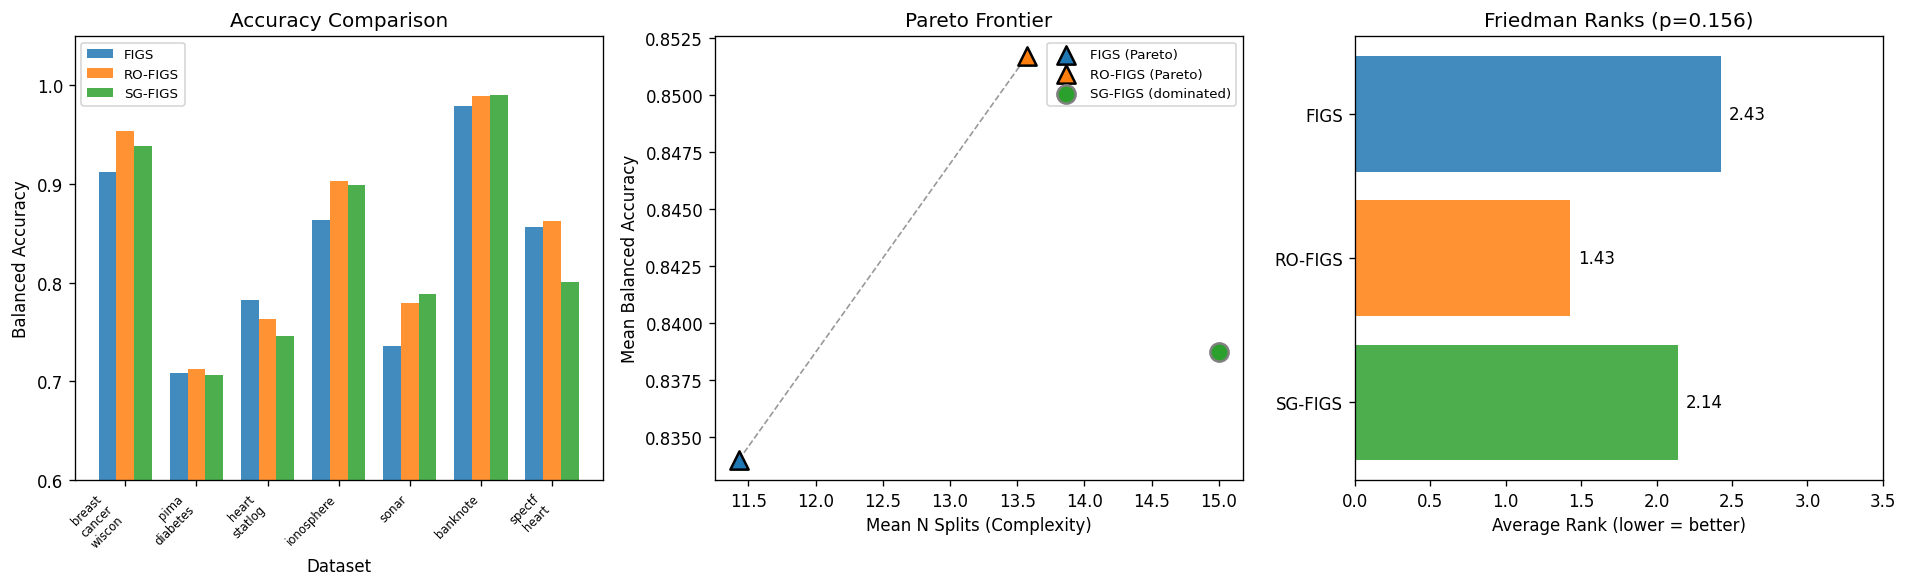


EVALUATION SUMMARY

Mean Balanced Accuracy:
  FIGS:    0.8400
  RO-FIGS: 0.8517
  SG-FIGS: 0.8387

Friedman: chi2=3.7143, p=0.156118
Wilcoxon RO vs SG: p=0.156250

Criterion 1: 2/7 pass (rate=0.2857)
Criterion 2: 3 datasets with index mismatch
Criterion 3: 4 datasets meaningful (MET)

Pareto: FIGS eff=0.0708, RO-FIGS eff=0.0628, SG-FIGS eff=0.0559
SG-FIGS on Pareto front: NO


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = {"FIGS": "#1f77b4", "RO-FIGS": "#ff7f0e", "SG-FIGS": "#2ca02c"}

# --- Plot 1: Accuracy comparison bar chart ---
ax = axes[0]
ds_labels = [ds.replace("_", "\n")[:20] for ds in complete_datasets]
x_pos = np.arange(len(complete_datasets))
bar_width = 0.25

for j, method in enumerate(METHODS):
    accs = [acc_per_dataset[ds][method] for ds in complete_datasets]
    ax.bar(x_pos + j * bar_width, accs, bar_width,
           label=method, color=colors[method], alpha=0.85)

ax.set_xlabel("Dataset")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Accuracy Comparison")
ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(ds_labels, rotation=45, ha="right", fontsize=7)
ax.legend(fontsize=8)
ax.set_ylim(0.6, 1.05)

# --- Plot 2: Pareto frontier ---
ax = axes[1]
for method in METHODS:
    if method in method_stats:
        s = method_stats[method]
        marker = "^" if method in pareto_dominant else "o"
        edge = "black" if method in pareto_dominant else "gray"
        ax.scatter(s["mean_n_splits"], s["mean_accuracy"],
                   s=120, color=colors[method], marker=marker,
                   edgecolors=edge, linewidths=1.5, zorder=5,
                   label=f"{method} ({'Pareto' if method in pareto_dominant else 'dominated'})")

# Draw Pareto front line for dominant methods
dom_points = [(method_stats[m]["mean_n_splits"], method_stats[m]["mean_accuracy"])
              for m in pareto_dominant if m in method_stats]
dom_points.sort()
if len(dom_points) >= 2:
    ax.plot([p[0] for p in dom_points], [p[1] for p in dom_points],
            "k--", alpha=0.4, linewidth=1)

ax.set_xlabel("Mean N Splits (Complexity)")
ax.set_ylabel("Mean Balanced Accuracy")
ax.set_title("Pareto Frontier")
ax.legend(fontsize=8)

# --- Plot 3: Average ranks ---
ax = axes[2]
rank_colors = [colors[m] for m in METHODS]
bars = ax.barh(METHODS, avg_ranks, color=rank_colors, alpha=0.85)
ax.set_xlabel("Average Rank (lower = better)")
ax.set_title(f"Friedman Ranks (p={p_value:.3f})")
ax.set_xlim(0, 3.5)
for bar, rank in zip(bars, avg_ranks):
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
            f"{rank:.2f}", va="center", fontsize=10)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# --- Summary table ---
print("\n" + "=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)
ma = data["metrics_agg"]
print(f"\nMean Balanced Accuracy:")
print(f"  FIGS:    {ma['mean_accuracy_figs']:.4f}")
print(f"  RO-FIGS: {ma['mean_accuracy_ro_figs']:.4f}")
print(f"  SG-FIGS: {ma['mean_accuracy_sg_figs']:.4f}")
print(f"\nFriedman: chi2={ma['friedman_statistic']:.4f}, p={ma['friedman_p_value']:.6f}")
print(f"Wilcoxon RO vs SG: p={ma['wilcoxon_ro_vs_sg_p']:.6f}")
print(f"\nCriterion 1: {ma['criterion1_n_pass']}/7 pass (rate={ma['criterion1_pass_rate']:.4f})")
print(f"Criterion 2: {ma['criterion2_n_index_mismatch']} datasets with index mismatch")
print(f"Criterion 3: {ma['criterion3_n_meaningful_datasets']} datasets meaningful ({'MET' if ma['criterion3_met'] else 'NOT MET'})")
print(f"\nPareto: FIGS eff={ma['pareto_figs_efficiency']:.4f}, "
      f"RO-FIGS eff={ma['pareto_ro_figs_efficiency']:.4f}, "
      f"SG-FIGS eff={ma['pareto_sg_figs_efficiency']:.4f}")
print(f"SG-FIGS on Pareto front: {'YES' if ma['pareto_sg_on_front'] else 'NO'}")